# Building a satellite data business with Python - some examples from Cibo Labs
By Peter Scarth

This notebook contains some examples of how we access and use cloud based earth observation data to build an operational data pileline at Cibo Labs. We'll cover:
- What Cibo Labs is, and who our users are
- How we collect field data
- How we access satellite imagery
- How we use Python to process and analyse satellite imagery
- Our cloud architecture

![Cibo Labs Pasture Key](https://github.com/petescarth/GEOM3001-7001/raw/main/images/intro.png)

![Cibo Labs Pasture Key](https://github.com/petescarth/GEOM3001-7001/raw/main/images/products.png)

# Building a cloud based pasture prediction stack
This session outlines a cloud-based workflow for building a total standing dry matter (TSDM) prediction model by calibrating field data to coincident Sentinel 2 imagery and then training a machine learning model to predict across the landscape.

It is a simplified version of the prediction and delivery method used by the startup company [Cibo Labs](https://www.cibolabs.com.au/pasturekey).

Being able to work using data sets on the cloud has a number of benefits.
 - Having the compute next to the imagery makes operations fast
 - Having access to fast data science platforms like [SageMaker](https://aws.amazon.com/sagemaker/) or [Google Colaboratory](https://research.google.com/colaboratory/) makes running experiments fast
 - Having access to scalable compute and free data makes the starting cost very low, and allows you to grow as your customer base grows

The [Cibo Labs](https://www.cibolabs.com.au/pasturekey) PastureKey process that we'll build a much simplified version of here is summarised in this diagram:

 ![Cibo Labs Pasture Key](https://github.com/petescarth/GEOM3001-7001/raw/main/images/process.png)


## The first step is to import all the python libraries we'll need
If you're new to this, I'd recommend starting with [Miniconda](https://docs.conda.io/en/latest/miniconda.html) then installing the required packages in a new environment. I'd also recommend replacing conda with [mamba](https://github.com/mamba-org/mamba) to speed up the solving of python dependencies. The Python geospatial stack is unfortunately full of dependency conflicts that can often cause issues so always use environments. In CiboLabs, we use docker and maintain a base container onto which we add components as required.

Something like this should work:
```
conda create --name geom3001 python=3.11
conda activate geom3001 
conda install -y -c conda-forge folium gdal geopandas imageio jupyterlab localtileserver matplotlib numpy pystac-client rasterio tensorflow 
```

In [2]:
# Importing 'timedelta' from 'datetime' module. This can be used to perform operations with time durations
from datetime import timedelta

# Importing numpy module (popularly aliased as np). Numpy is used for handling arrays, matrices and related mathematical operations
import numpy as np  

# Importing matplotlib's pyplot (aliased as plt), a plotting library used for 2D graphics
import matplotlib.pyplot as plt 

# Importing imread function from imageio.v2, used to read an image from a file 
from imageio.v2 import imread 

# Importing GDAL module from osgeo package for handling geospatial data
from osgeo import gdal 

# Importing geopandas (aliased as gp) for working with geospatial data in Python
import geopandas as gp 

# Importing folium for visualizing geospatial data on interactive map
import folium

# Importing rasterio, a Python library for reading and writing geospatial raster datasets
import rasterio 

# Importing tensorflow (aliased as tf), a machine learning framework
import tensorflow as tf 

# Importing Client from pystac_client. STAC makes finding geospatial data easy by providing common metadata and API.
from pystac_client import Client 

# Importing get_folium_tile_layer and TileClient to view geospatial data on interactive map
from localtileserver import get_folium_tile_layer, TileClient


# Calling function 'UseExceptions' under 'gdal'.
# This makes GDAL raise Python exceptions for GDAL errors,
# allowing the programmer to handle these exceptions using Python exception handling mechanisms.
gdal.UseExceptions() 



2024-07-27 18:13:31.235766: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-27 18:13:31.353726: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Organize Field Data

Field data is collected in the field using [Open Data Kit (ODK)](https://getodk.org/)
A form that allows the user to capture location, a photo and the Total Standing Dry Matter (TSDM) of pasture is given to producers.

Grass is cut from a known area using a quadrat, weighed when cut, then dried and weighed again. These measurements are scaled to give TSDM, or the weight of dry grass in the paddock which is the primary input to building farm forage budgets. Cattle will eat 2.5 to 3% of their body weight in dry matter per day, so a 300kg steer or heifer requires a pasture allowance of about 10kg DM/day to achieve potential animal growth.

![Cibo Labs Pasture Key](https://github.com/petescarth/GEOM3001-7001/raw/main/images/datacollection.png)


### Load the data
Normally we'd pull the data directly from a PostGIS database, but here we will use a [FlatGeoBuf](https://flatgeobuf.org/) file hosted on github. It's one of the few cloud optimised vector file formats. We prefix the location with [/vsicurl/](https://gdal.org/user/virtual_file_systems.html#vsicurl-http-https-ftp-files-random-access) to indicate to Geopandas that we want to read from a web endpoint. We could also use /vsis3/ to read directly from a AWS S3 bucket if the file was hosted there.

transect_id  tsdm  points_center_lat  \
0  rqgsioklsvaukfyrtprndywruvjfhesx  1400         -25.673810   
1  pmrrncgczplamiqrffexbsevkfjtcxzy  1335         -25.674966   
2  ehtgxxdmqufrmjcpyvylhqmpfjjypaji  1845         -25.664339   
3  kcfisqqjhujgxothionficnmnfaoofkf  4630         -25.680011   
4  criebpvmarctjkawpdcqqidcxfhvmflr  2150         -25.663473   

   points_center_lng sample_date                     geometry  
0         151.779993  2020-05-21  POINT (151.77999 -25.67381)  
1         151.773798  2020-05-21   POINT (151.7738 -25.67497)  
2         151.771542  2020-05-22  POINT (151.77154 -25.66434)  
3         151.768055  2020-05-21  POINT (151.76806 -25.68001)  
4         151.755347  2020-05-21  POINT (151.75535 -25.66347)

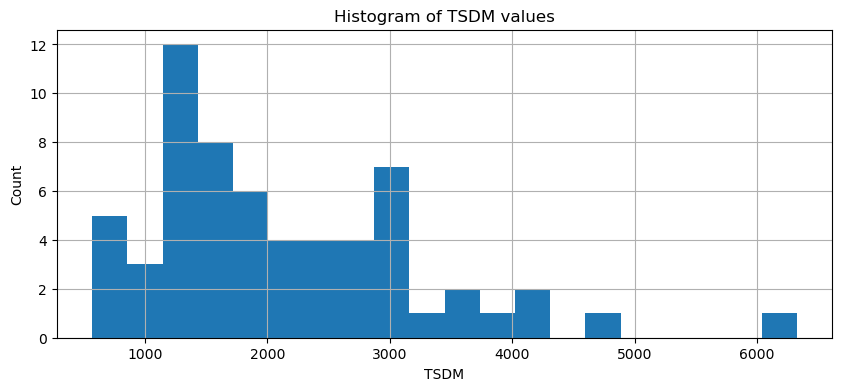

In [8]:
# Read the field data directly from the web without downloading the dataset
FIELD_DATA = '/vsicurl/https://github.com/petescarth/GEOM3001-7001/raw/main/data/odkFieldData.fgb'

# Load the field data into a geopandas dataframe
fieldData = gp.read_file(FIELD_DATA)

# Plot a histogram of the TSDM values to check the data range
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.hist(fieldData.tsdm, bins=20);
ax.set_ylabel('Count')
ax.set_xlabel('TSDM')
ax.set_title('Histogram of TSDM values')
ax.grid()

# Print the header to inspect the data
fieldData.head()



### Plot the data using Matplotlib on the Dataframe
[Geopandas](https://geopandas.org/) simplifies working with vector data in Python. Here we simply plot where the data is.

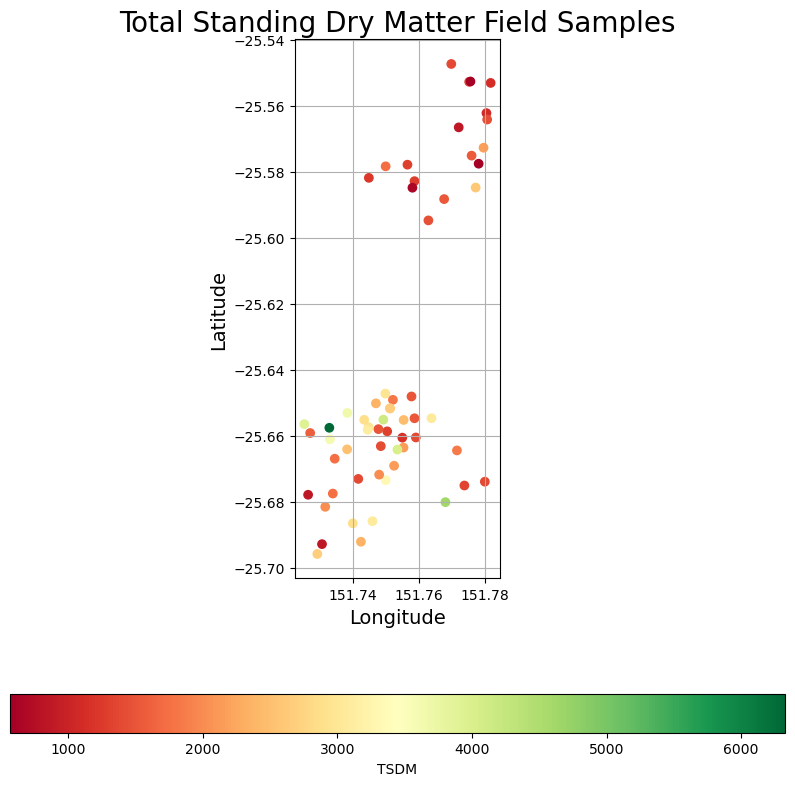

In [5]:
# Plot the dataframe using pandas with a grid spacing of 0.02 degrees
ax = fieldData.plot(figsize=(10,10), aspect='equal', column='tsdm',
                    cmap='RdYlGn', legend=True, legend_kwds={'label': "TSDM", 'orientation': "horizontal"})
# Set title and labels
ax.set_title("Total Standing Dry Matter Field Samples", fontsize=20)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
# Create a grid
ax.grid(True,)
# Get rid of the offset on the x-axis
ax.get_xaxis().get_major_formatter().set_useOffset(False)

## Select the best Sentinel 2 image from AWS
We want to find the most cloud free image close to the field data acquisition date. Pasture mass can change quickly in the growing season, or if grazed so we try to get imagery as close as possible to the date people were in the field. We could also use the cloud masks that come with the imagery if no cloud free scenes were available - it's just a slightly more complicated workflow.
To do this we:
 - filter from the 1,000,000's of images using the dates and bounds of the field data
 - select the tile with the lowest cloud to extract pixel values from to build a prediction model

### First create the time range and bounding box for the search:


In [6]:
bufferDate = 5 # days buffer around field work dates

# Work out the date range of the field data buffered by the specified number of days
earliestImageDate = (fieldData.sample_date.min() - timedelta(days=5)).strftime("%Y-%m-%d")
latestImageDate = (fieldData.sample_date.max() + timedelta(days=5)).strftime("%Y-%m-%d")

# Use these dates to make a time range filter to use in the STAC query
timeRange = f"{earliestImageDate}/{latestImageDate}"

# Work out the bounding box of the field data to use in the STAC query
bbox = fieldData.total_bounds

# Print some info to the screen
print(f'Searching for imagery between {earliestImageDate} and {latestImageDate} using a bounding box of\n{bbox}')

Searching for imagery between 2020-05-14 and 2020-06-01 using a bounding box of
[151.7252935 -25.695717  151.7817585 -25.5472235]


#### Now search the STAC catalog
The [SpatioTemporal Asset Catalogs](https://stacspec.org) (STAC) specification is a common language to describe geospatial information, so it can more easily be worked with, indexed, and discovered.

A spatiotemporal asset is any file that represents information about the earth captured in a certain space and time.

Here we use PySTAC, a library for working with STAC, to find the Sentinel 2 tiles of interest in the [Sentinel-2 Cloud-Optimized GeoTIFFs](https://registry.opendata.aws/sentinel-2-l2a-cogs/) AWS Bucket 

In [7]:
# Search the Element84 STAC catalog
client = Client.open("https://earth-search.aws.element84.com/v1")
s2Search = client.search(
    collections=['sentinel-2-l2a'],
    datetime = timeRange,
    bbox=bbox
    )

# Show the results of the search
print(f"{s2Search.matched()} items found:\n{list(s2Search.items())}")


8 items found:
[<Item id=S2A_56JLS_20200529_0_L2A>, <Item id=S2A_56JLS_20200529_1_L2A>, <Item id=S2B_56JLS_20200524_0_L2A>, <Item id=S2B_56JLS_20200524_1_L2A>, <Item id=S2A_56JLS_20200519_1_L2A>, <Item id=S2A_56JLS_20200519_0_L2A>, <Item id=S2B_56JLS_20200514_1_L2A>, <Item id=S2B_56JLS_20200514_0_L2A>]


#### Show thumbnails and some information on the found Sentinel 2 Tiles
STAC results are returned as "Pages" of results, to avoid overwhelming the calling process with 1000's of results. The logic in the following code  is to:
 - look through each "page" of results,
 - look at the items in each page and download the JPEG thumbnail for each tile as a quick look
 - keep track of the item with the lowest cloud for further analysis - the 'bestItem'



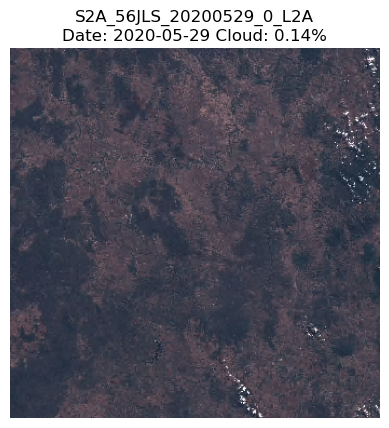

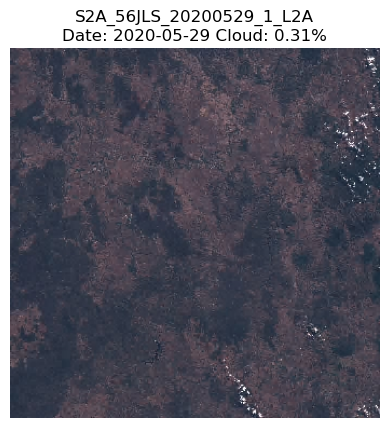

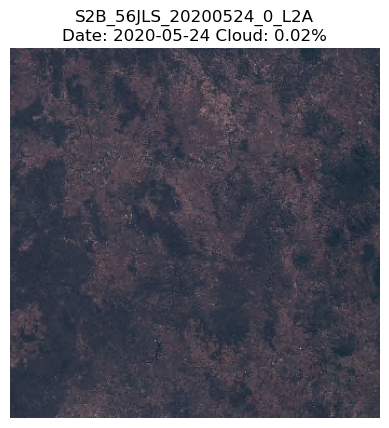

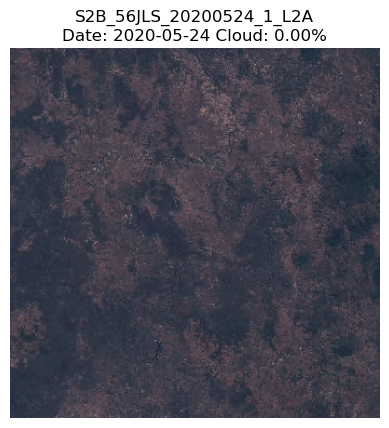

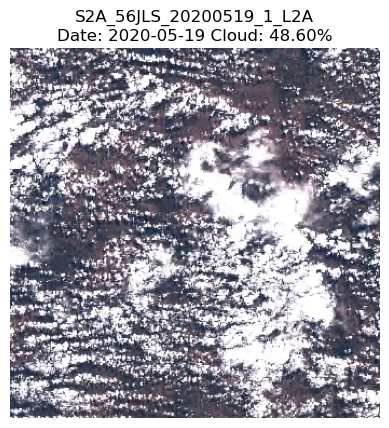

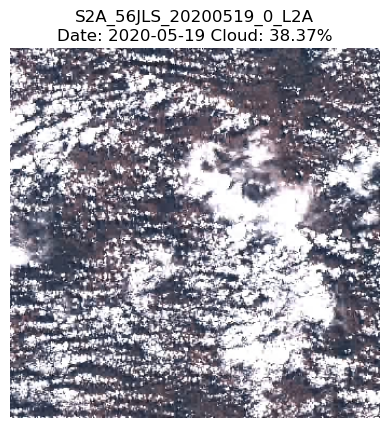

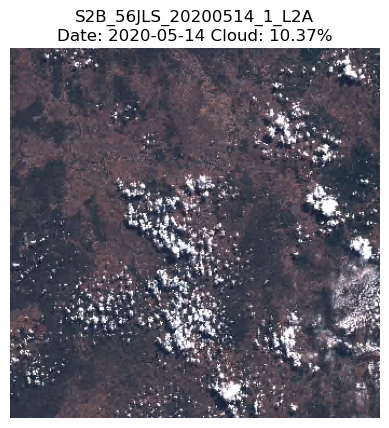

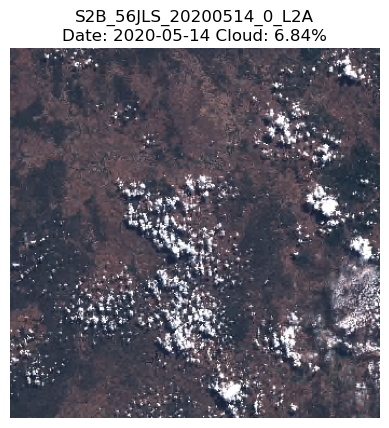

S2B_56JLS_20200524_1_L2A had the lowest cloud cover of 0.00353%


In [14]:
# Variables to keep track of the Sentinel 2 asset, or item, with the lowest cloud cover
lowestCloudCover = 101  # Initialize the lowest cloud cover variable to a value higher than any possible cloud cover percentage
bestItem = None  # Initialize the bestItem variable to None

# Loop for each page of results from the search object
for page in s2Search.pages():
    
    # Loop for each item in a page
    for item in page:
        
        # Get the amount of cloud cover from the item properties
        cloudAmount = item.properties['eo:cloud_cover']
        
        # If the cloud amount is lower than the current lowest cloud cover, update the lowest cloud cover and best item
        if cloudAmount < lowestCloudCover:
            lowestCloudCover = cloudAmount
            bestItem = item
        
        # Read the thumbnail of the Sentinel 2 asset, or item, and display it in a figure.
        # The thumbnail is a small image of the asset, used to show the user what the asset looks like.
        # The imread function reads the image, which is a jpeg, and returns it as a numpy array.
        thumbnail = imread(item.assets["thumbnail"].href)
        
        # Show the thumbnail image. Note: This operation may time out on slow connections.
        plt.imshow(thumbnail)
        
        # Add some metadata as the title. Metadata typically includes date and cloud cover information.
        dateString = item.get_datetime().strftime('%Y-%m-%d')  # Format the item's datetime to a readable string format
        plt.title(f"{item.id}{chr(10)}Date: {dateString} Cloud: {cloudAmount:.2f}%")  # Display item ID, date, and cloud cover as the plot title
        plt.axis('off')  # Hide the axes for better visual presentation
        
        # Notebook Trick: pause allows the notebook to render the plot
        plt.pause(1)  # Pause for 1 second to ensure the plot updates correctly in a Jupyter notebook

# Print some information about the best item found
print(f"{bestItem.id} had the lowest cloud cover of {lowestCloudCover}%")


#### Have a look at the best item properties
A Spatio-Temporal Catalog item is actually just a python dictionary, and they are quite easy to see directly in a notebook.

In [13]:
bestItem  

<Item id=S2B_56JLS_20200524_1_L2A>

### Show the sites and the bounds of the 'Best Image' on a Slippy map
[Folium](https://python-visualization.github.io/folium/) uses [Leaflet](https://leafletjs.com/) (an open-source JavaScript library for mobile-friendly interactive maps) in the background to embed "Slippy" maps directly into notebooks.


In [12]:
# Plot the dataframe using folium - first make the map with some defaults
# Initialize the map centered around the average latitude and longitude of the field data points
map = folium.Map(
    location=[fieldData.points_center_lat.mean(), fieldData.points_center_lng.mean()],
    tiles="OpenStreetMap",  # Set the base layer to OpenStreetMap
    zoom_start=9  # Initial zoom level
)

# Add the field points to the map
folium.features.GeoJson(
    fieldData[['geometry', 'tsdm']].to_json(),  # Convert the relevant columns to GeoJSON format
    tooltip=folium.GeoJsonTooltip(fields=['tsdm'])  # Add a tooltip that shows the TSDM value for each point
).add_to(map)  # Add the GeoJson object to the map

# Get the bounding box from the STAC item
bbox = bestItem.bbox  # Extract the bounding box coordinates

# Create a rectangle corresponding to the best image
rectangle = folium.vector_layers.Rectangle(
    bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],  # Define the rectangle's bounds using the bounding box coordinates
    color="#ff7800",  # Border color of the rectangle
    fill=True,  # Enable filling the rectangle area with color
    fill_color="#ffff00",  # Fill color
    fill_opacity=0.2  # Opacity of the fill color
).add_to(map)  # Add the rectangle to the map

# Show the map
map  # Display the map in the output (Note: In Jupyter Notebook or similar environments, you may need to use `map.save('map.html')` to save and view it.)


## Build a GDAL VRT file to access the Sentinel 2 data directly from AWS
There are a few ways of doing this, but the key is using GDAL's [virtual filesystem support](https://gdal.org/user/virtual_file_systems.html)

GDAL's [Virtual format (VRT)](https://gdal.org/drivers/raster/vrt.html) method allows the user to control things like:
 - resampling
 - mosaicing of tiles
 - output spatial resolution
 - output radiometric resolution and datatype
 - band ordering 
 - output projection
 - output data type
 - color tables
 - even band math on the fly

On AWS, the Sentinel bands are kept as separate assets called B01.tif, B02.tif etc. Because the Sentinel 2 bands have differing spatial resolutions this makes sense.

I like being able to access one Sentinel Tile as one file so I stack all the individual bands.

Here we use the "best" Sentinel 2 tile identified above and build a virtual representation of it using [gdalbuildvrt](https://gdal.org/programs/gdalbuildvrt.html)


In [15]:
# This can take a little while to run as GDAL needs to open each band before making the VRT

# Create a name for the VRT (Virtual Raster Table) file using the ID of the best item found
vrtName = bestItem.id + '.vrt'
print(f'Making: {vrtName}')

# List of the Sentinel-2 band names we're looking to stack in the VRT
s2BandNames = ['blue', 'green', 'red', 'rededge1', 'rededge2', 'rededge3', 'nir', 'swir16', 'swir22']

# List to hold the URLs of the individual bands
urlList = []

# Loop through each band name
for band in s2BandNames:
    # Get the URL for the current band from the item's assets
    url = bestItem.assets[band].href
    print(url)
    # Add the URL to the list with the prefix '/vsicurl/' to allow GDAL to read the data directly from the URL
    urlList.append('/vsicurl/' + url)

# Set some options for creating the VRT file
vrtOptions = gdal.BuildVRTOptions(
    resampleAlg='average',  # Resampling algorithm to use (average)
    separate=True,          # Keep each band as a separate layer within the VRT
    resolution='lowest'     # Use the lowest resolution available among the input bands
)

# Create the VRT file using the list of URLs and the specified options
vrtData = gdal.BuildVRT(vrtName, urlList, options=vrtOptions)

# Close the VRT file after we're done creating it
vrtData = None


Making: S2B_56JLS_20200524_1_L2A.vrt
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B02.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B03.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B04.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B05.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B06.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B07.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B08.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B11.tif
https://sentinel-co

#### Test the VRT by calling gdalinfo
[gdalinfo](https://gdal.org/programs/gdalinfo.html) simply lists information about a raster data set.

In [18]:
!gdalinfo {vrtName}

Driver: VRT/Virtual Raster
Files: S2B_56JLS_20200524_1_L2A.vrt
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B02.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B03.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B04.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B05.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B06.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B07.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_1_L2A/B08.tif

### Access the Sentinel Data through the VRT
One of the cool things about [Cloud Optimized GeoTIFFs](https://www.cogeo.org) is that if you request a reduced spatial resolution it will read from the file overviews (often called pyramid layers).

This keeps data transfers low.

The cell below:
- Reads a three band reduced resolution (512 x 512 pixel) thumbnail of the Sentinel data using [rasterio](https://rasterio.readthedocs.io/en/latest/) on the VRT
- Stretches the data using a percentile stretch to make a pleasing visual image
- Displays the image in the notebook

(-0.5, 511.5, 511.5, -0.5)

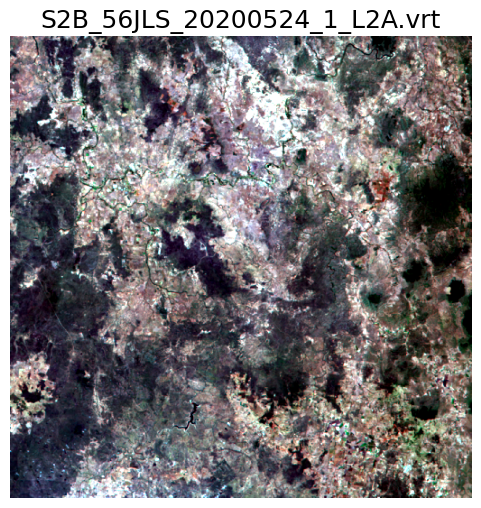

In [16]:
# List of the bands we want to read from the VRT (using 1-based indexing)
bandList = [3, 2, 1]

# Open the VRT file using Rasterio
cloudRaster = rasterio.open(vrtName)

# Read only the specified bands and resize the output to a 512x512 thumbnail
falseColourThumbnail = cloudRaster.read(bandList, out_shape=(3, 512, 512))

# Reorder the dimensions for matplotlib (bands should be the last dimension)
falseColourThumbnail = np.rollaxis(falseColourThumbnail, 0, 3)

# Perform a 2-98% linear stretch to scale the data values
scaleStats = np.percentile(falseColourThumbnail, [2, 98], axis=(0, 1))
falseColourThumbnail = (falseColourThumbnail - scaleStats[0]) / (scaleStats[1] - scaleStats[0])

# Clip the data values to be within the range 0 to 1
falseColourThumbnail = np.clip(falseColourThumbnail, 0, 1)

# Plot the false-color thumbnail image using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(falseColourThumbnail, aspect=1)

# Add the VRT name as the title of the plot
ax.set_title(vrtName, fontsize=18)
# Hide the axis for better visualization
ax.axis('off')


## Link the field TSDM data to the image
We want to link the field data to the reflectance of the coincident pixel so that we can build a prediction model for TSDM.

This is pretty easy using [Rasterio's sample module](https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html) once we have a list of coordinates in the same projection as the image data.


In [18]:
# Open the VRT using Rasterio
cloudRaster = rasterio.open(vrtName)

# Reproject the geometry to match the raster coordinate system
fieldProjectedGeometry = fieldData.geometry.to_crs(cloudRaster.crs)

# Build a list of coordinate pairs to pass to Rasterio's sample function
coordList = [(x,y) for x,y in zip(fieldProjectedGeometry.x , fieldProjectedGeometry.y)]

# Print the number of coordinates in the list and some information on the raster
print(f'There are {len(coordList)} coordinates to be extracted from the raster')

# Sample the raster (without downloading the entire raster) and add it to the dataframe as a list of values
fieldData['Sentinel2'] = [x for x in cloudRaster.sample(coordList)]

# Show what the fielddata dataframe looks like now
fieldData.head()


There are 61 coordinates to be extracted from the raster


transect_id  tsdm  points_center_lat  \
0  rqgsioklsvaukfyrtprndywruvjfhesx  1400         -25.673810   
1  pmrrncgczplamiqrffexbsevkfjtcxzy  1335         -25.674966   
2  ehtgxxdmqufrmjcpyvylhqmpfjjypaji  1845         -25.664339   
3  kcfisqqjhujgxothionficnmnfaoofkf  4630         -25.680011   
4  criebpvmarctjkawpdcqqidcxfhvmflr  2150         -25.663473   

   points_center_lng sample_date                     geometry  \
0         151.779993  2020-05-21  POINT (151.77999 -25.67381)   
1         151.773798  2020-05-21   POINT (151.7738 -25.67497)   
2         151.771542  2020-05-22  POINT (151.77154 -25.66434)   
3         151.768055  2020-05-21  POINT (151.76806 -25.68001)   
4         151.755347  2020-05-21  POINT (151.75535 -25.66347)   

                                           Sentinel2  
0  [438, 602, 777, 1163, 1572, 1736, 1951, 2556, ...  
1  [475, 626, 951, 1221, 1441, 1626, 1866, 3082, ...  
2  [270, 409, 481, 866, 1466, 1678, 1829, 1883, 1...  
3  [462, 639, 1007, 1218, 1513, 1670, 2002, 2537,...  
4  [400, 568, 743, 1078, 1435, 1590, 1787, 2564, ...

## Build a Tensorflow Multi Layer Perceptron (MLP) model to predict Total Standing Dry Matter
We define and train a very simple [MLP Model](https://en.wikipedia.org/wiki/Multilayer_perceptron) in [Tensorflow Keras](https://keras.io/). This is just one of many machine learning models that could be appropriate for this task, and I introduce it here as an alternative to the very popular (in remote sensing) [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model. We use Tensorflow because it trains fast on a GPU, the Keras API is reasonably accessible, and it has great hardware support running on x86 and ARM CPUs, TPUs, and even in the [browser](https://www.tensorflow.org/js).

 - We scale the field and image data into the 0-1 range
 - Use the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) function due to it's robustness to outliers from  dodgy field data
 - Use the [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) optimiser
 - Train it for 500 iterations, using 33% of the field data for validation
 - Plot the training and validation losses

The model architecture we're using here is represented in the diagram below.

![Cibo Labs Pasture Key](https://github.com/petescarth/GEOM3001-7001/raw/main/images/nn.png)



/home/pete/miniconda3/envs/geom3001/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


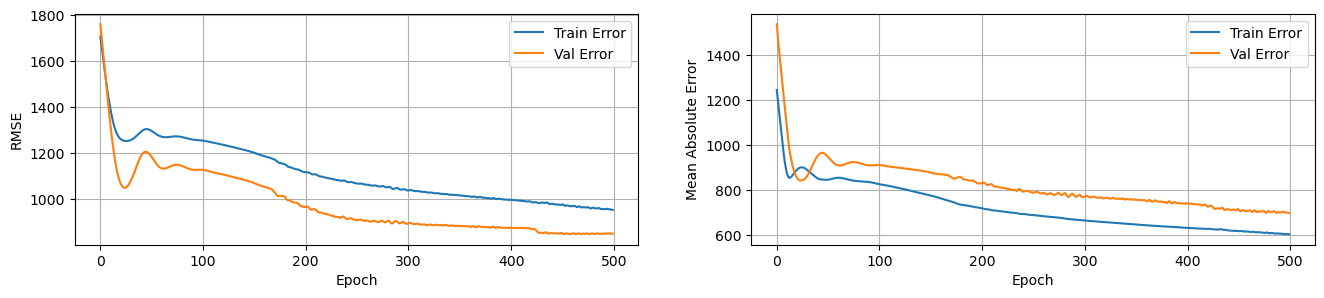

In [19]:
# Shuffle the data to remove spatial and temporal correlations
fieldData.sample()

# Extract features (X) and target variable (y) from the dataframe into numpy arrays
# X contains Sentinel-2 data, y contains field TSDM (Total Standing Dry Matter) data
X = np.array(fieldData['Sentinel2'].to_list(), dtype=np.float32)
y = np.array(fieldData['tsdm'], dtype=np.float32)

# Scale the data to a range from 0 to 1
X = X / 10000  # Scale Sentinel-2 data to reflectance values
y = y / 10000  # Scale TSDM data to t/Ha/10

# Build a simple 3-layer neural network using the Keras library
tsdmMLP = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=[X.shape[1]]),  # Input layer with 8 neurons and ReLU activation
    tf.keras.layers.Dense(8, activation='relu'),                           # Hidden layer with 8 neurons and ReLU activation
    tf.keras.layers.Dense(8, activation='relu'),                           # Another hidden layer with 8 neurons and ReLU activation
    tf.keras.layers.Dense(1)                                               # Output layer with a single neuron (regression task)
])

# Compile the model using the Huber loss function and the Adam optimizer
tsdmMLP.compile(
    loss=tf.keras.losses.Huber(delta=0.05),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mean_absolute_error', 'mean_squared_error']
)

# Fit the model to the data using 500 training epochs and a validation split of 33%
history = tsdmMLP.fit(
    X, y,
    epochs=500,
    validation_split=0.33,
    shuffle=True,
    batch_size=1024,
    verbose=0
)

###############################################################################################
# Plot the training process results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 3))

# Plot the Root Mean Squared Error (RMSE) loss function (unscaled to original units)
ax1.plot(history.epoch, 10000 * np.sqrt(history.history['mean_squared_error']), label='Train Error')
ax1.plot(history.epoch, 10000 * np.sqrt(history.history['val_mean_squared_error']), label='Val Error')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('RMSE')
ax1.grid()
ax1.legend()

# Plot the Mean Absolute Error (MAE) loss function
ax2.plot(history.epoch, 10000 * np.array(history.history['mean_absolute_error']), label='Train Error')
ax2.plot(history.epoch, 10000 * np.array(history.history['val_mean_absolute_error']), label='Val Error')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.grid()
ax2.legend()


## Use the Tensorflow model to predict on the full data set
In this example we're accessing the image from the cloud and writing locally, but this could happen entirely on the cloud.

First we define a function that takes the Sentinel 2 bands and returns a predicted TSDM value.

Then we apply that model block by block to the Sentinel 2 data read from AWS in Oregon.

Because we are processing the full image, and pulling the data across from the US, this takes a while.

In operational use, you would typically process only your region of interest at the desired spatial resolution to save compute.

Rather than reading the entire image, we use blocks of imagery called [windows](https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html) to minimise memory use, and can be used to parallelize the process if more CPU's are available.

We are careful to compress the tiff file, write it in tiles, and generate overviews (or pyramid layers) so that processes using it can efficiently access it on the cloud as well.

This is not a fully [Cloud Optimized GeoTiff](https://www.cogeo.org/) but in practice it is quite close. The final GeoTiff can be made fully COG complient by using a tool like Airbus' [COGGER](https://github.com/airbusgeo/cogger) which reads an internally tiled geotiff and rewrites it as a Cloud Optimized Geotiff (COG) by reshuffling the original geotiff's bytes.

In [26]:
# Make a filename for the prediction using the VRT name
tsdmImageName = vrtName.replace('.vrt','_tsdm.tif')
print(f'Making: {tsdmImageName}')

###############################################################################################
# The prediction function that takes a numpy array of data and a tensorflow model object
# Returns a numpy array of TSDM predictions
def predictTsdm(nbar, tsdmMLP):
    
    # Get the shape of the input sentinel 2 array
    inshape = nbar.shape
    
    # Flatten the array to Bands x Pixels and scale the reflectance like when we trained the model
    nbar = np.reshape(nbar,(inshape[0],-1)) / 10000.0
    
    # Run the prediction on the tensorflow model. Increase the batch size to 512 x 512 to speed up the prediction
    tsdm = tsdmMLP.predict(nbar.T,batch_size=262144, verbose =0)
    
    # Round and clip the predictions from 1 to 10000 kg/Ha
    tsdm = np.clip(np.round(tsdm * 10000),1,10000)

    # Handle nodata in the input by making output nodata values 0
    tsdm[nbar[0] ==0 ] = 0
    tsdm[nbar[0] > 1] = 0
    
    # Reshape the output back to the input shape and return it
    return np.reshape(tsdm,(1,inshape[1],inshape[2])).astype(np.uint16)

###############################################################################################
# Apply the prediction function to the raster
# First open the raster using Rasterio
with rasterio.open(vrtName) as src:
    
    # Print the size and number of bands in the raster
    print(f'Raster size: {src.width} x {src.height}')
    print(f'Tile size: {src.block_windows(0).__next__()[1].width} x {src.block_windows(0).__next__()[1].height}')
    print(f'Number of bands: {src.count}')  
    
    # Set the output file metadata from the input raster
    kwargs = src.meta
    # Set the output driver to GTiff
    kwargs['driver']='GTIFF'
    # Set the number of bands to 1
    kwargs['count']=1
    # Set the output nodata value to 0
    kwargs['nodata']=0
    # Set the output datatype to uint16
    kwargs['dtype']='uint16'
    
    # Use the rasterio windowed tiling iterator
    tiles = src.block_windows(0)
    
    # Open the output file for writing with compression and tiling
    with rasterio.open(tsdmImageName, 'w', **kwargs,
                         compress="DEFLATE",
                         tiled=True, 
                         blockxsize=128, 
                         blockysize=128) as dst:
        
        # Iterate through the tiles
        for idx, window in tiles:
            # Read the data from the input raster
            srcData = src.read(window=window).astype(np.float32)
            
            # Run the prediction function defined above on the data
            dstData = predictTsdm(srcData,tsdmMLP)
            
            # Write the data to the output raster
            dst.write(dstData, window=window)

            # Print the tile progress followed by a carriage return to overwrite the line
            print(f'Completed tile: {idx[0]} x {idx[1]}  \r', end='')

        
        # Before closing the file, build overviews so that the raster can be viewed quickly in QGIS or on the cloud
        dst.build_overviews([2, 4, 8, 16, 32, 64, 128, 256])



Making: S2B_56JLS_20200524_1_L2A_tsdm.tif
Raster size: 5490 x 5490
Tile size: 128 x 128
Number of bands: 9


### Plot the TSDM image
Now we've run the prediction across the entire image, we can view it next to the original data to check the prediction.

We use the same Rasterio based image reading and the stretch introduced previously to view the two images side by side.


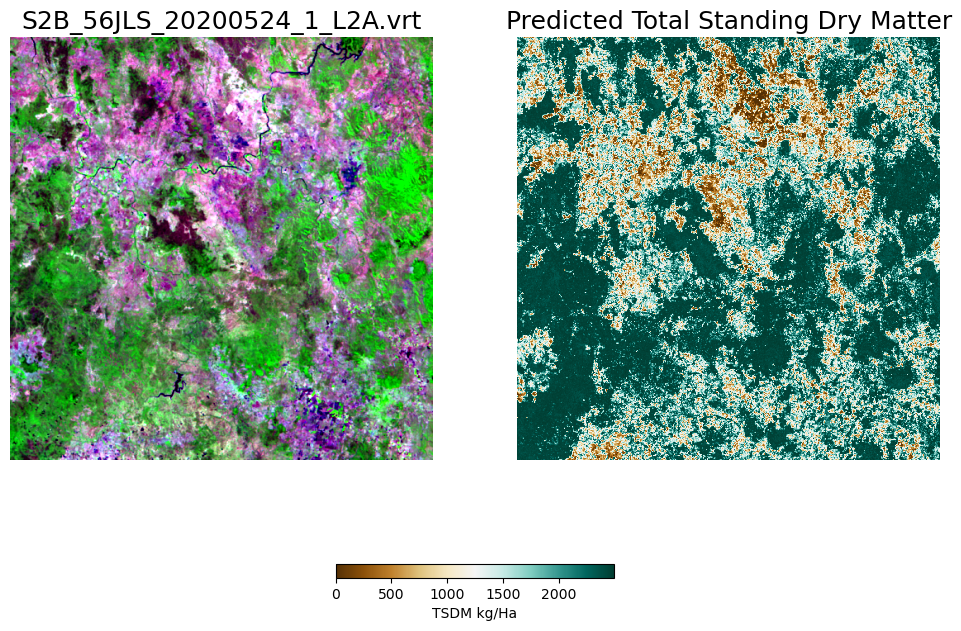

In [23]:
# Get the name of the TSDM image
tsdmImageName = vrtName.replace('.vrt','_tsdm.tif')

# Load the Sentinel-2 data into an array ready to plot
cloudRaster = rasterio.open(vrtName)

# Get the data for the specified bands [8, 7, 3] using a decimated read (downsampled to 512x512)
falseColourThumbnail = cloudRaster.read([8, 7, 3], out_shape=(3, 512, 512))

# Change the band ordering from (bands, height, width) to (height, width, bands) for matplotlib compatibility
falseColourThumbnail = np.rollaxis(falseColourThumbnail, 0, 3)

# Scale the data using a 2:98% stretch to enhance image contrast
scaleStats = np.percentile(falseColourThumbnail, [2, 98], axis=(0, 1))
falseColourThumbnail = (falseColourThumbnail - scaleStats[0]) / (scaleStats[1] - scaleStats[0])

# Clip the data values to be within the range [0, 1]
falseColourThumbnail = np.clip(falseColourThumbnail, 0, 1)

# Load the TSDM (Total Standing Dry Matter) raster into an array ready to plot
tsdmRaster = rasterio.open(tsdmImageName)

# Get the data for the first band using a decimated read (downsampled to 512x512)
tsdmThumbnail = tsdmRaster.read(1, out_shape=(1, 512, 512))

# Scale the data using a 2:98% stretch to enhance contrast
scaleStats = np.percentile(tsdmThumbnail, [2, 98], axis=(0, 1))
tsdmThumbnail = (tsdmThumbnail - scaleStats[0]) / (scaleStats[1] - scaleStats[0])

# Clip the data values to be within the range [0, 1] and then scale by the maximum TSDM value
tsdmThumbnail = np.clip(tsdmThumbnail, 0, 1) * scaleStats[1]

# Plot the images side by side with a legend
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))

# Plot the false color Sentinel-2 image
ax1.imshow(falseColourThumbnail, aspect=1)
ax1.set_title(vrtName, fontsize=18)
ax1.axis('off')

# Plot the TSDM prediction
im = ax2.imshow(tsdmThumbnail, aspect=1, cmap='BrBG')
ax2.set_title('Predicted Total Standing Dry Matter', fontsize=18)
ax2.axis('off')

# Add a colorbar for the TSDM image
cbar = fig.colorbar(im, ax=[ax1, ax2], location='bottom', shrink=0.3)
cbar.set_label('TSDM kg/Ha')


## Make the result available as a web service
This uses the Developmentseed [TiTiler](https://developmentseed.org/titiler/) library.

_"A modern dynamic tile server built on top of FastAPI and Rasterio/GDAL"_

It is a cloud-first image tiler that takes an image (or a mosaic of images) and serves them up to users on the web via a [Swagger]() api.

 It can be hosted on a regular server, and also as a serverless [AWS Lambda function](https://aws.amazon.com/lambda/) or as a Docker container on an [Elastic Container Service](https://docs.aws.amazon.com/AmazonECS/latest/developerguide/Welcome.html). 

It is also able to apply stretches, color tables, calculate statistics and compute band math functions on the fly.

For this to work, the image must be hosted on a web server, preferably in cloud optimized format. 

For this demonstration I'll run this using a local webserver, but in production the image would be on a cloud web server or in a cloud bucket (like S3 etc).

If you are running this yourself, the server will run at `localhost` on your local machine.
### Links - Only active while webserver is running - I will route geom3001.space to this machine.

 - http://geom3001.space
 - http://geom3001.space/cog/viewer
 - https://tinyurl.com/best-image
 - https://tinyurl.com/grass-mass




## Call the XYZ tile server and add them to our webmap

The tiler API exposes lots of endpoints that you can see by visiting the servers /api.html page

Here we just use the standard XYZ tile server method, as used by Google Maps, Open Streetmap etc and add it as an additional tile layer to our map.

In [22]:
# Plot the dataframe using folium - first make the map with some defaults
map = folium.Map(
    location=[fieldData.points_center_lat.mean(), fieldData.points_center_lng.mean()],
    tiles="OpenStreetMap",
    zoom_start=10
)

# Add the field points to the map within a specific FeatureGroup
field_points_layer = folium.FeatureGroup(name='Field Points').add_to(map)

# Add GeoJson layer to the 'Field Points' FeatureGroup with tooltip showing TSDM values
folium.features.GeoJson(
    fieldData[['geometry', 'tsdm']].to_json(),
    tooltip=folium.GeoJsonTooltip(fields=['tsdm'])
).add_to(field_points_layer)

# Get the bounding box from the STAC item (e.g., Sentinel-2 image bounding box)
bbox = bestItem.bbox

# Create a rectangle on the map corresponding to the bounding box of the best image
rectangle = folium.vector_layers.Rectangle(
    bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
    color="#ff7800",
    fill=False,
    tooltip='Sentinel 2 Image Bounds',
).add_to(map)

# Add TSDM tile layers to their respective feature groups and add them to the map
layer_tsdm = folium.FeatureGroup(name='Estimated TSDM').add_to(map)
layer_tsdm.add_child(get_folium_tile_layer(
    TileClient(tsdmImageName), vmin=scaleStats[0], vmax=scaleStats[1], colormap='BrBG'))

# Add Sentinel-2 tile layers to their respective feature groups and add them to the map
layer_nbar = folium.FeatureGroup(name='Sentinel 2 Image').add_to(map)
layer_nbar.add_child(get_folium_tile_layer(
    TileClient(vrtName), indexes=[8, 7, 3]))

# Add Layer Control to enable switching between different layers on the map
folium.LayerControl().add_to(map)

# Display the map
map


## Summary
This cloud workflow example is only touching the surface of what is possible, but the take home message is that being able to understand the opportunities, and/or be able to work programmatically in cloud based systems, is a very useful (_and employable_) skill to acquire.

Processing massive amounts of satellite data is now available to anyone, through frameworks like the Google Earth Engine, Open Data Cube, Sentinel Hub and Microsoft Planetary Computer. The process outlined in this notebook could be easily undertaken in any of these. 

The reasons you might want to build your own cloud processing workflow could be to:
 - reduce costs, 
 - utilize a technology stack not available elsewhere, 
 - utilize data formats not available elsewhere, 
 - integrate datasets not available natively on a chosen platform; or 
 - to just have greater certainty around platform changes or deprecations.

For Cibo Labs, the critical cloud technologies used are based on a more traditional HPC computing stack rather then tools like docker, kubernetes and AWS Lambda (although we also leverage these in production where appropriate). In particular we make heavy use of:
 - AWS Batch to run Gravitron (ARM) instances using spot pricing to minimize costs when processing machine learning models on thousands of Sentinel 2 tiles or running zonal statistics across millions of polygons, currently costing around USD4600/month.
 - Aurora Serverless PostGIS databases which give us a fully scalable spatial database to store, aggregate, cluster and deliver billions of precomputed statistics against various spatial aggregations (like Cadastre, NRM regions, Postcodes etc) currently costing around USD 1600/month.

A cloud solution will typically take a number of these technologies and connect them to make a production workflow. As a final example, our full pasture prediction process is captured in this diagram:

![Cibo Labs Pasture Key](https://github.com/petescarth/GEOM3001-7001/raw/main/images/pasturekey.png)
